
## Fastai 3D images


### Resources

* https://towardsdatascience.com/working-with-3d-data-fastai2-5e2baa09037e 
* https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai
* https://forums.fast.ai/t/fastai-v2-has-a-medical-imaging-submodule/56117
* https://towardsdatascience.com/deep-learning-with-magnetic-resonance-and-computed-tomography-images-e9f32273dcb5

Fastai

* Pipelines and Transforms - https://docs.fast.ai/tutorial.pets
* Info on batch and item transforms - https://docs.fast.ai/vision.data#ImageDataLoaders
  - item transforms happen one item at a time on the CPU
  - batch transforms happen one batch at a time on the GPU
* Blocks tutorial - https://docs.fast.ai/tutorial.datablock.html


Pytorch

* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Note that Fastai defaults to DICOM and doesn't appear to support NIFTI. 

### Notes

* Most of your types Blocks extend or compose TransformBlock.  They just call type, item and batch transforms.
* Pipelines would call a bunch of transforms at one time. 
* Transforms seem to be the key thing. consider writing these correctly first.
* Once you have the transforms you can figure out if you want to use a TfmsList or Dataset or DataBlock. 
* Consider inheriting from "ItemTransform". Can you see if you can get your to batch to "show" by writing "decode"?


In [1]:
from fastai.data.all import *
from fastai.vision.all import *
import os.path

In [33]:
%load_ext autoreload
%autoreload 2

from utils import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Write a DataBlock. 

It will give you back a Dataset and DataLoader


To build a DataBlock you need to give the library four things: 
 
* the types of your input/labels, and at least two functions: `get_items` and `splitter`. 
* You may also need to include `get_x` and `get_y` or a more generic list of getters that are applied to the results of get_items.



In [3]:
#example DataBlock - won't run.

dblock = DataBlock(
    blocks    = (ImageSequenceBlock, CategoryBlock),
    get_items = SequenceGetItems('file', 'sequence_id', 'label'), 
    get_x     = lambda t : t[:-1],
    get_y     = lambda t : t[-1],
    splitter  = RandomSplitter())

NameError: name 'ImageSequenceBlock' is not defined

In [4]:
#this is the definition of an ImageBlock in the fast.ai codebase.
def ImageBlock(cls=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)


In [5]:
#what is the format of get_items? 

In [25]:
#https://docs.fast.ai/data.transforms.html#get_files
files = get_files('./data/small/t1', extensions='.gz', recurse=False)

In [4]:
files[0]

Path('data/small/t1/IXI167-HH-1569-T1_fcm.nii.gz')

In [5]:
type(files)

fastcore.foundation.L

From the first link in the resource section:

> remember from the DataBlock example above that get_x and get_y receive the output from get_items and should separate what is the input and what is the target. In this case, they are as simple as this:

In [48]:


class NiftiGetItems():

    def __init__(self):
        pass
        
    def __call__(self, source_dir):
        
        #TODO: could just take the parent directory
        t1_files = os.listdir(source_dir)

        subj_list = [ path_to_subj(e) for e in t1_files if fnmatch(e, r'*T1_fcm.nii.gz') ] 
        
        out = [] 
        
        for s in subj_list:
            t1 = load_mr_image(s, "t1")
            t2 = load_mr_image(s, "t2")           
            out.append({'source': t1, 'target': t2})

        return out

class ShowNiftiSlice:
    def __init__(self, arr, slice_num=45):
        self.img_arr = arr[:,:, slice_num]
        
    def show(self, **kwargs): show_image(self.img_arr, **kwargs)

class NiftiTfm(ItemTransform):
    '''
    Take a set of items which are file names in setups
    Take a single file name in encodes, return a tuple with (src, target) both of which are numpy arrays. 
    Take (s:np.ndarray, t:np.ndarray) in decodes, figure out how to present one or two images.  
    '''
    def setups(self, fns):
        self.source_files = fns
        
    
    def encodes(self, fn:Path):
        subj = path_to_subj(fn)
        s = load_mr_image(subj, "t1")
        t = load_mr_image(subj, "t2")
                
        return (s.get_fdata().astype('float'), t.get_fdata().astype('float'))
    
    def decodes(self, x):
        return ShowNiftiSlice(x[1])
         

#https://fastcore.fast.ai/transform#Transform (how do these differen from pytorch transforms?)
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms
class NumpyToTensor(ItemTransform):
    '''
    Not sure if the regular toTensor will work with just a numpy array. might only work with PILImage. 
    '''
    
    def setups(self, items):
        pass
    
    def encodes(self, o):
        pass
    
    def decodes(self, x):
        pass


def pathsToNifiObjs(image_file_tuples):
    #Note: this could be turned into a transform. 
    #Note: you may be able to skip this. Only works if you refactor the NiftiGetItems() to return a path. 
    pass
    
def create_batch(data):
    
    print('in create_batch')
    print(data)
    print(len(data))
    xs = []
    ys = []
    for s in data:
        print('calling TT')
        t = ToTensor(s) #this is wrong. Need to construct an obj then call it. 
        print('got a tensor')
        xs.append(t['source'])
        ys.append(t['target'])
    print('leaving create_batch')
    return (xs, ys)

#question does DataLoader do the transform to a tensor in pytorch? Not Dataset?


#This class is only needed if you decide to make GetItems just return paths. 
def NiftiBlock():
    return TransformBlock(item_tfms=NiftiToTensor(),
                          #batch_tfms= crop or data augment here...
                          #type_tfms= pathsToNiftiObjs
                         )
    

In [11]:
dblock = DataBlock(
    #blocks    = NiftiBlock(),
    #blocks    = [TransformBlock(item_tfms=[ToNumpy(), AddDim(),])], #this is the wrong format. should be (sourceBlock, targetblock). This could maybe be a pipeline. 
    get_items = NiftiGetItems(),
    get_x     = lambda t : t['source'], 
    get_y     = lambda t : t['target'],
    #n_inp = how many inputs do you want to pass into the datablock / get_items, etc. 
    splitter  = RandomSplitter())

#TODO: See above. 
# - crop is not happening. Fix this. 
# - not creating tensors. 

In [11]:
dsets = dblock.datasets('./data/small/t1')

In [12]:
dsets

(#28) [(<nibabel.nifti1.Nifti1Image object at 0x7f9dcce2aa30>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf2069a0>),(<nibabel.nifti1.Nifti1Image object at 0x7f9caf2063a0>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf206c10>),(<nibabel.nifti1.Nifti1Image object at 0x7f9caf4837f0>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf25c5e0>),(<nibabel.nifti1.Nifti1Image object at 0x7f9caf4836a0>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf211370>),(<nibabel.nifti1.Nifti1Image object at 0x7f9caf2112b0>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf211040>),(<nibabel.nifti1.Nifti1Image object at 0x7f9caf211dc0>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf483820>),(<nibabel.nifti1.Nifti1Image object at 0x7f9caf211280>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf211d60>),(<nibabel.nifti1.Nifti1Image object at 0x7f9caf1ab1f0>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf1ab070>),(<nibabel.nifti1.Nifti1Image object at 0x7f9caf1ab280>, <nibabel.nifti1.Nifti1Image object at 0x7f9caf1ab

In [15]:
dls = dblock.dataloaders('./data/small/t1', bs=8, create_batch=create_batch) 

in create_batch
[(<nibabel.nifti1.Nifti1Image object at 0x7efaeea5f400>, <nibabel.nifti1.Nifti1Image object at 0x7efaeea59190>)]
1
calling TT
Could not do one pass in your dataloader, there is something wrong in it


In [77]:
type(dsets)

fastai.data.core.Datasets

In [64]:
dsets.train[0]

(<nibabel.nifti1.Nifti1Image at 0x7ffa7d0e12e0>,
 <nibabel.nifti1.Nifti1Image at 0x7ffa7d0e1550>)

In [15]:
ToTensor()(dsets.train[0])

#LEFT OFF HERE. NOT SURE WHY THIS DIDN'T WORK. TRY A TRANSFORMED LIST (TfmdList). See the Pipeline and transforms tutorial. 



in ToTensor
here


AttributeError: 'Nifti1Image' object has no attribute 'transpose'

In [23]:
a = dsets.train[0]
#TODO: turn this into a TransformBlock ? 
b = ToNumpy()(a)  
c = AddDim()(b)
d = ToTensor()(c)
d

in ToTensor
here


(tensor([[[[ 1.1064e-28,  2.6875e-23,  1.5517e-19,  ..., -6.5872e-18,
             4.7015e-18, -1.4260e-21],
           [ 1.0044e-18,  6.2352e-18,  2.8831e-17,  ...,  1.7370e-10,
            -2.5201e-11,  2.3136e-14],
           [ 2.8891e-17,  1.7935e-16,  5.1307e-15,  ...,  4.2897e-09,
             4.9453e-11,  6.6545e-13],
           ...,
           [ 4.1844e-19, -1.3712e-07, -3.9062e-06,  ...,  4.7797e-05,
            -3.0614e-06, -1.3534e-08],
           [ 5.2593e-18, -3.5583e-06, -1.0138e-04,  ...,  1.2287e-03,
            -7.8700e-05, -3.4792e-07],
           [-2.3027e-18, -1.9536e-07, -5.6225e-06,  ..., -4.1198e-06,
             2.6404e-07,  1.1666e-09]],
 
          [[-2.3321e-15, -9.7401e-15, -2.7863e-13,  ..., -4.2805e-13,
             7.5283e-12,  2.2763e-16],
           [ 6.0129e-16,  1.5016e-11,  4.3153e-10,  ...,  1.3986e-04,
            -1.6346e-05, -7.2220e-08],
           [-1.8859e-15,  1.7291e-12,  4.7141e-11,  ...,  5.8584e-04,
            -3.6260e-05, -1.6031e-07],


In [ ]:
#these are the transforms I'd need to run on nifti.  
#can these be part of a TransformBlock? 
#would they be batch transforms? 
#when does the tansform get called in vanilla pytorch? just when you construct a batch? 
transforms.Compose([RandomCrop3D(cube_crop_dim), 
                                                            ToNumpy(), 
                                                            AddDim(), 
                                                            ToTensor()]),

In [10]:
fastai.data.transforms.ToTensor

fastai.data.transforms.ToTensor

In [11]:
tt = fastai.data.transforms.ToTensor()

In [22]:
n = np.arange(96).reshape((1,2,3,4,4))

In [23]:
t = tt(n)

In [24]:
type(t)
#weird...why not pytorch Tensor...

#ToTensor might only be applied to certain types of images. Like PILImage objects. 

numpy.ndarray

In [26]:
tensor

<function fastai.torch_core.tensor(x, *rest, dtype=None, device=None, requires_grad=False, pin_memory=False)>

In [58]:
tfm = NiftiTfm()
fns = get_files('./data/small/t1', extensions='.gz', recurse=False)
tfm.setup(fns)
tup = tfm(fns[0])

In [50]:
snf = tfm.decode(tup)

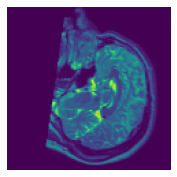

In [51]:
snf.show()

In [52]:
tfm_pipe = Pipeline([NiftiTfm(), fastai.data.transforms.ToTensor()])
tfm_pipe.setup(fns)

> <ipython-input-53-2ad80a3c0cbe>(1)<module>()
----> 1 x,y = tfms(fns[0])

ipdb> n


In [54]:
x,y = tfm_pipe(fns[0])

In [55]:
x.shape

(120, 120, 90)

In [56]:
y.shape

(120, 120, 90)

In [57]:
type(y) #not a tensor...

numpy.ndarray